In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Lung Cancer')

In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from collections import OrderedDict

import cv2
import yaml
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from tqdm import tqdm
from scipy import ndimage as ndi
from scipy.ndimage import label, generate_binary_structure
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

from src.losses import BCEDiceLoss
from src.dataset import LIDCDataset
from src.unetpp_model import UNet
from src.unetpp_model import UNetPP
from src.unet_utils import DoubleConv, OutConv, Down, Up
from src.training_utils import AverageMeter, str2bool
from src.training_utils import iou_score, dice_coef, dice_coef2, accuracy_score, precision_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True

In [ ]:
model = UNet(n_channels=1, n_classes=1, bilinear=True)
model.load_state_dict(torch.load('/content/drive/MyDrive/Lung Cancer/final_model.pth'))
model = model.to(device)

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/Lung Cancer/data/Detected/Image/'
MASK_DIR = '/content/drive/MyDrive/Lung Cancer/data/Detected/Mask/'
meta = pd.read_csv('/content/drive/MyDrive/Lung Cancer/data/Meta/detected_meta.csv')

meta['original_image'] = meta['original_image'].apply(lambda x:IMAGE_DIR+ x +'.npy')
meta['mask_image'] = meta['mask_image'].apply(lambda x:MASK_DIR+ x +'.npy')

In [ ]:
meta_vink = pd.read_xlsx('/content/drive/MyDrive/Segmentation/test_mask_filenames_final_with_sem_feat.xlsx')

In [ ]:

test_image_paths = list(meta_vink['original_image'])
test_mask_paths = list(meta_vink['mask_image'])

In [ ]:
OUTPUT_MASK_DIR = '/content/drive/MyDrive/Lung Cancer/image output'

In [ ]:
test_dataset = LIDCDataset(test_image_paths, test_mask_paths, False)

# Create Dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=12)

model.eval()

In [ ]:
def save_output(output,output_directory,test_image_paths,counter):
    # This saves the predicted image into a directory. The naming convention will follow PI
    for i in range(output.shape[0]):
        label = test_image_paths[counter][-23:]
        #label = label.replace('NI','PD')
        np.save(output_directory+'/'+label,output[i,:,:])
        #print("SAVED",output_directory+label+'.npy')
        counter+=1
    return counter

avg_meters = {'iou': AverageMeter(),
              'dice': AverageMeter(),
              'accuracy': AverageMeter(),
              'precision': AverageMeter()}

In [ ]:
with torch.no_grad():
  counter = 0
  pbar = tqdm(total=len(test_loader))
  for input, target in test_loader:
    input = input.cuda()
    target = target.cuda()

    output = model(input)
    iou = iou_score(output, target)
    dice = dice_coef2(output, target)
    accuracy = accuracy_score(output, target)
    precision = precision_score(output, target)

    avg_meters['iou'].update(iou, input.size(0))
    avg_meters['dice'].update(dice, input.size(0))
    avg_meters['accuracy'].update(accuracy, input.size(0))
    avg_meters['precision'].update(precision, input.size(0))


    postfix = OrderedDict([
        ('iou', avg_meters['iou'].avg),
        ('dice',avg_meters['dice'].avg),
        ('accuracy',avg_meters['accuracy'].avg),
        ('precision',avg_meters['precision'].avg)
        ])

    output = torch.sigmoid(output)
    output = (output>0.5).float().cpu().numpy()
    output = np.squeeze(output,axis=1)

    counter = save_output(output,OUTPUT_MASK_DIR,test_image_paths,counter)
    pbar.set_postfix(postfix)
    pbar.update(1)
  pbar.close()

In [ ]:
print('IoU: {:.4f}'.format(avg_meters['iou'].avg))
print('DICE:{:.4f}'.format(avg_meters['dice'].avg))
print('Accuracy:{:.4f}'.format(avg_meters['accuracy'].avg))
print('Precision:{:.4f}'.format(avg_meters['precision'].avg))

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/Lung Cancer/data/Detected/Image/'
MASK_DIR = '/content/drive/MyDrive/Lung Cancer/data/Detected/Mask/'
PREDICT_DIR = '/content/drive/MyDrive/Segmentation/image output test set/'

In [ ]:
img = np.load('/content/drive/MyDrive/Lung Cancer/data/Detected/Image/LIDC-IDRI-0118/0118_DI002_slice002.npy')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig('img1.pdf')

In [ ]:
img = np.load('/content/drive/MyDrive/Segmentation/image output test set/0118_DI002_slice002.npy')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig('img2.pdf')

In [ ]:
img = np.load('/content/drive/MyDrive/Lung Cancer/data/Detected/Mask/LIDC-IDRI-0142/0142_DM002_slice000.npy')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig('img3.pdf')

In [ ]:
def view_img_save(MASK_DIR, PREDICT_DIR, IMAGE_DIR, save_path):
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))  # Create a 5x3 grid of subplots
    i = 0
    for idx, prediction in enumerate(os.listdir(PREDICT_DIR)[15:20]):  # Only loop over 5 items
        pid = 'LIDC-IDRI-' + prediction[:4]
        mask_id = prediction.replace('DI', 'DM')
        image_id = prediction

        # Load the images
        original_img = np.load(IMAGE_DIR + '/' + pid + '/' + image_id)
        mask_img = np.load(MASK_DIR + '/' + pid + '/' + mask_id)
        predict_mask = np.load(PREDICT_DIR + '/' + prediction)

        # Plot the images in the corresponding row
        axes[idx, 0].imshow(original_img, cmap='gray')
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].grid()

        axes[idx, 1].imshow(mask_img, cmap='gray')
        axes[idx, 1].set_title('True Mask')
        axes[idx, 1].grid()

        axes[idx, 2].imshow(predict_mask, cmap='gray')
        axes[idx, 2].set_title('Predicted Mask')
        axes[idx, 2].grid()

        # Hide axes for better visual display
        for ax in axes[idx]:
            ax.axis('off')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Save the figure
    #plt.savefig(save_path, dpi=300)
    plt.show()

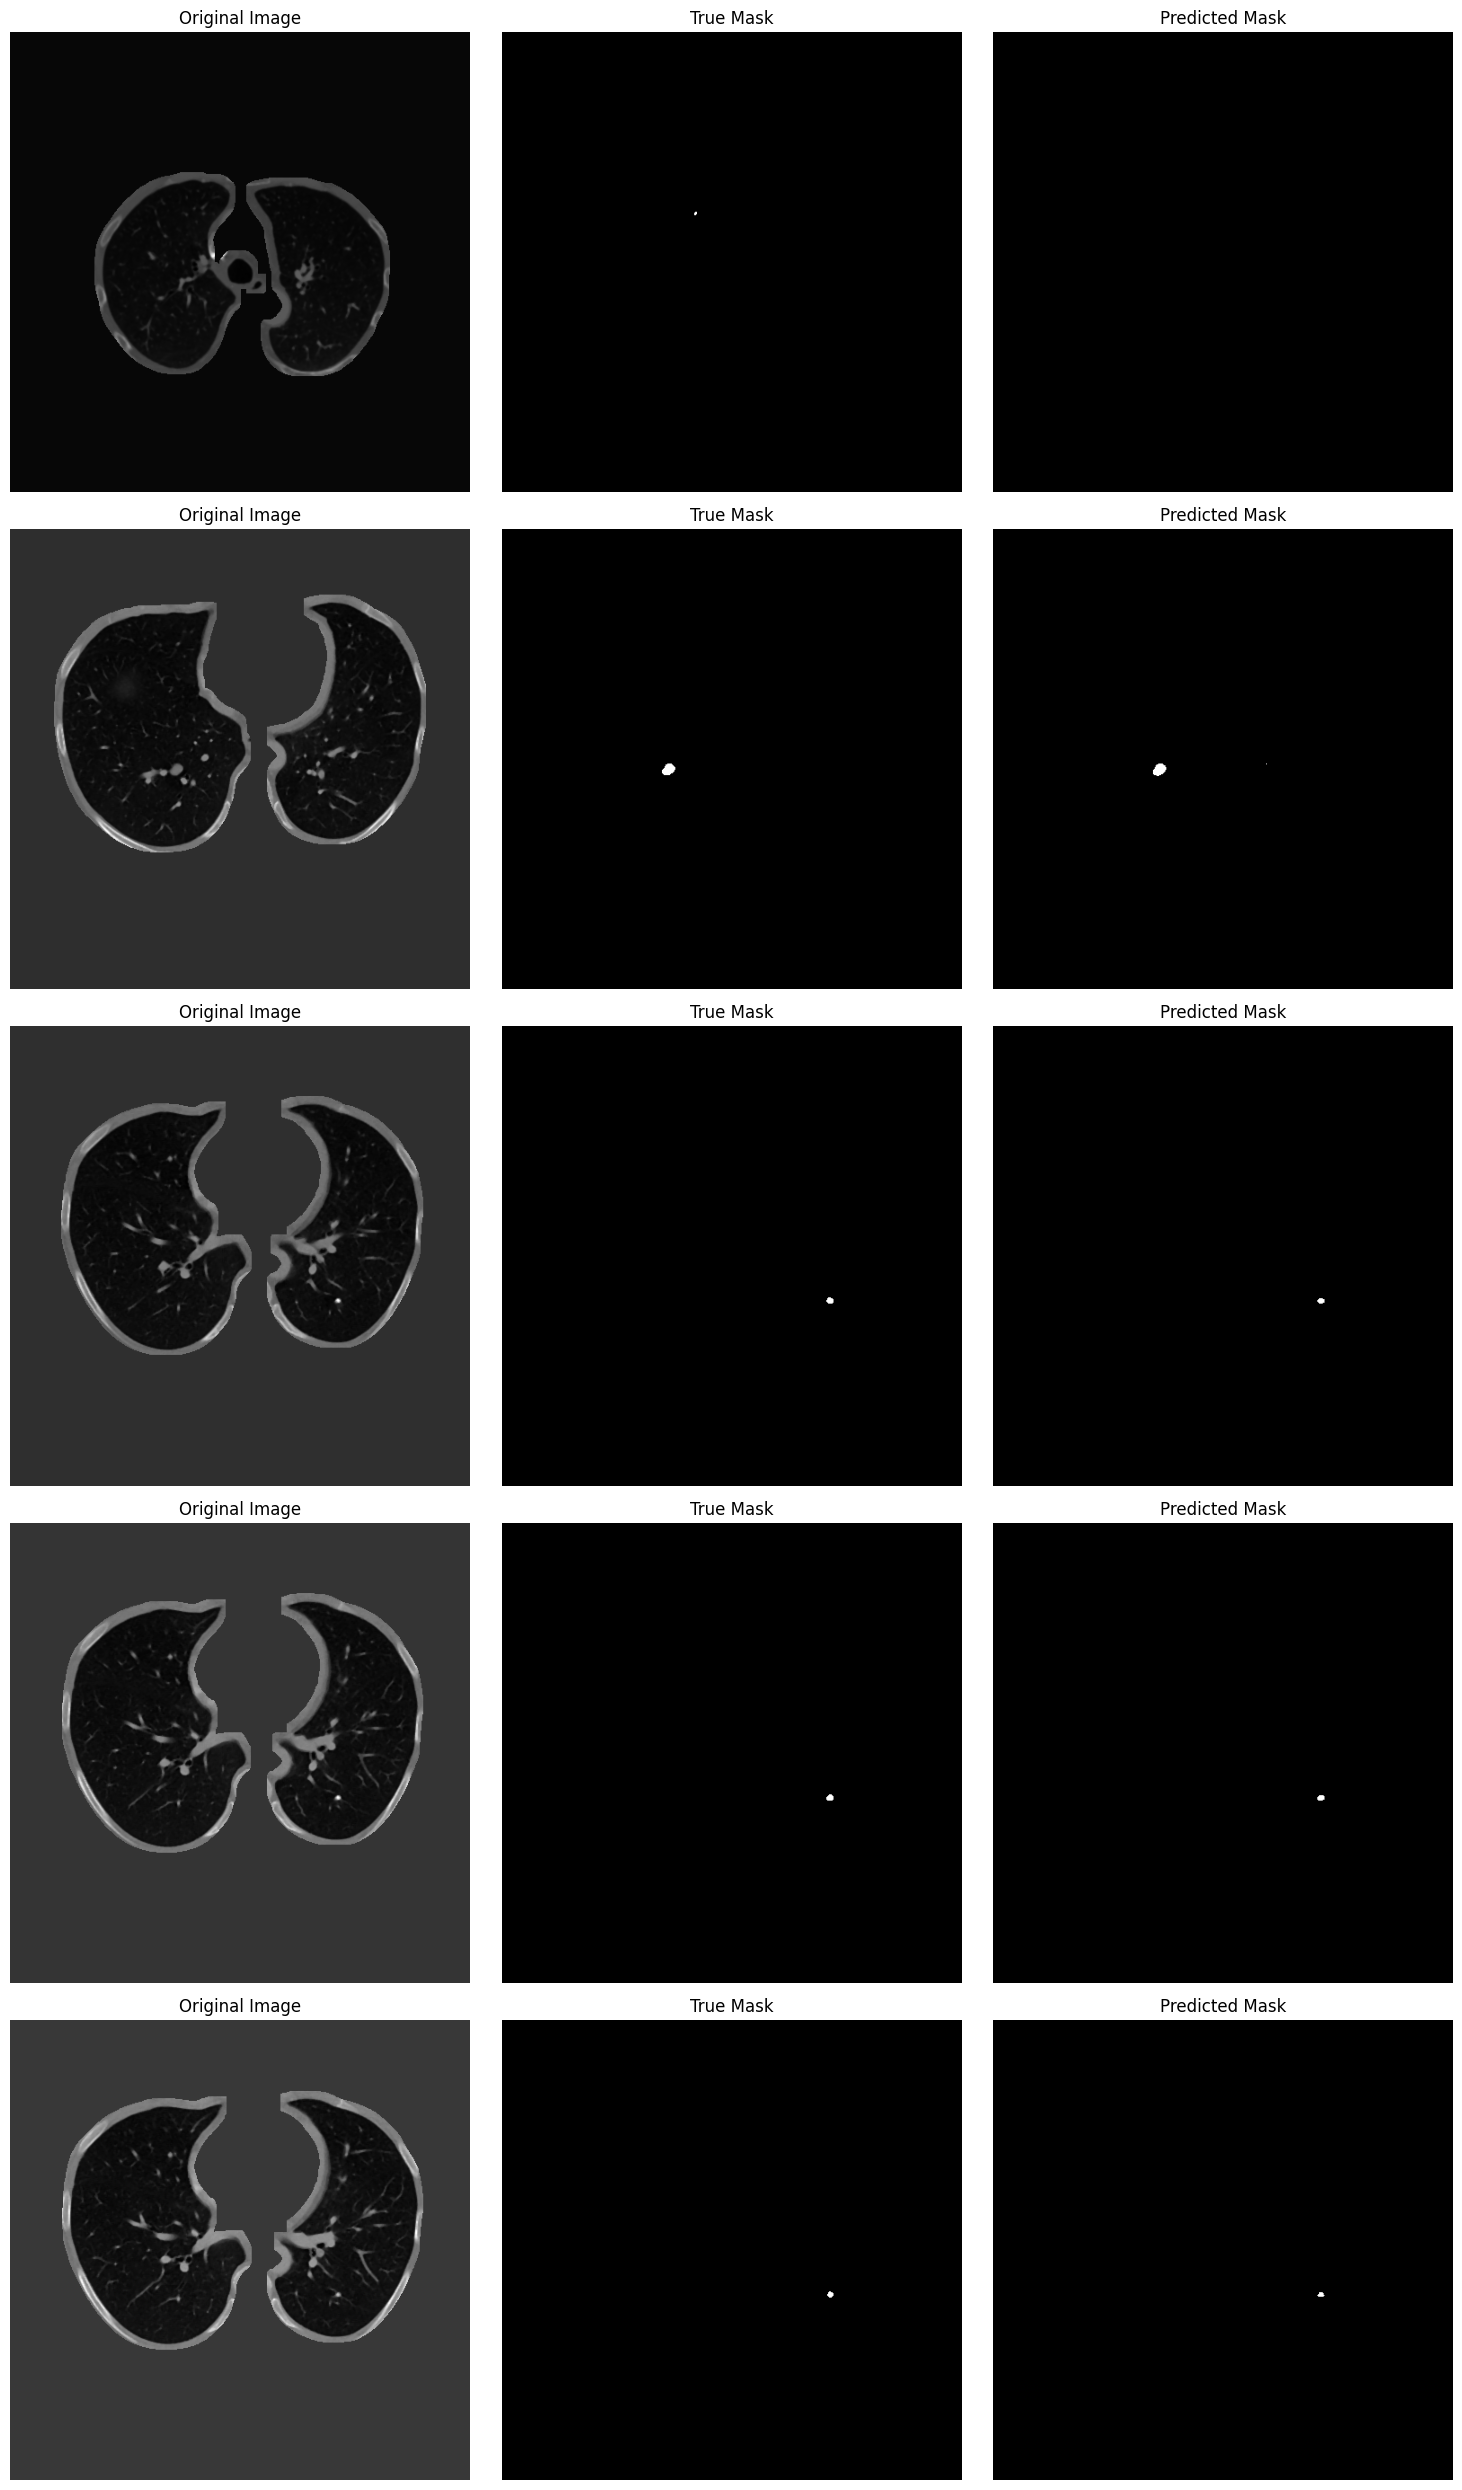

In [ ]:
view_img_save(MASK_DIR,PREDICT_DIR,IMAGE_DIR, 'hello')

In [ ]:
def view_img(MASK_DIR,PREDICT_DIR,IMAGE_DIR):
    i = 0
    for prediction in os.listdir(PREDICT_DIR)[30:40]:
        i+=1
        pid = 'LIDC-IDRI-'+prediction[:4]
        mask_id = prediction.replace('DI','DM')
        image_id = prediction

        original_img= np.load(IMAGE_DIR+'/'+pid+'/'+image_id)
        mask_img= np.load(MASK_DIR+'/'+pid+'/'+mask_id)
        predict_mask =np.load(PREDICT_DIR+'/'+prediction)

        fig,ax = plt.subplots(1,3, figsize=(15,15))
        print(pid,prediction)
        ax[0].title.set_text('Original image')
        ax[0].imshow(original_img, cmap='gray')
        ax[0].grid()
        ax[1].title.set_text('Mask image')
        ax[1].imshow(mask_img, cmap='gray')
        ax[1].grid()
        ax[2].title.set_text('Predicted Mask image')
        ax[2].imshow(predict_mask, cmap='gray')
        ax[2].grid()
        plt.savefig(f'image{i}.pdf')
        plt.show()